In [131]:
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

### get tissue outline

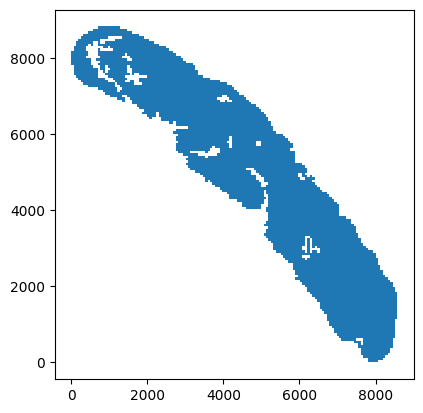

In [23]:
gdf = gpd.read_file('patches/h1810898A  h&e_ROI_2/tissue.geojson')
polygon = gdf.geometry.values[0]

for geom in gdf.geometry:
    gpd.GeoSeries(geom).plot()

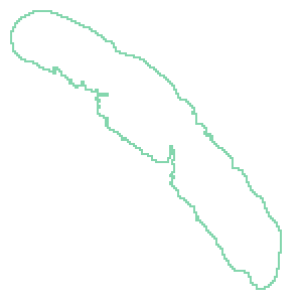

In [24]:
tissue = polygon.exterior
tissue_outline = np.array(tissue.coords)
tissue

### turn epithelium into points

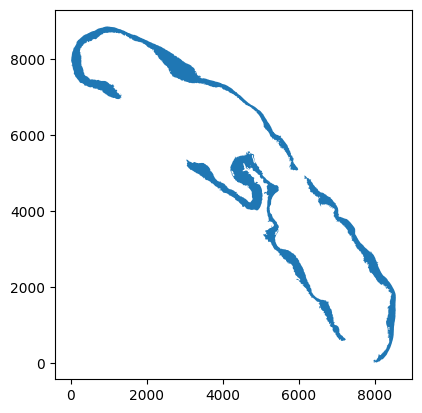

In [4]:
gdf = gpd.read_file('patches/h1810898A  h&e_ROI_2/epithelium.geojson')
polygon = gdf.geometry.values[0]

for geom in gdf.geometry:
    gpd.GeoSeries(geom).plot()

In [5]:
# array of exterior coordinates
# ep_exterior = []

# for geom in gdf.geometry:
#     if geom.is_empty:
#         continue
    
#     if geom.geom_type in ['Polygon', 'MultiPolygon']:
#         if geom.geom_type == 'Polygon':
#             exterior_points = np.array(geom.exterior.coords)
#             ep_exterior.extend(exterior_points.tolist()) 
#         elif geom.geom_type == 'MultiPolygon':
#             for poly in geom.geoms:
#                 exterior_points = np.array(poly.exterior.coords)
#                 ep_exterior.extend(exterior_points.tolist())

# ep_exterior_array = np.array(ep_exterior)

In [6]:
# array of all coordinates
ep_all = []

# ep_all.append(ep_exterior)

# extract interior coordinates
for geom in gdf.geometry:
    if geom.is_empty:
        continue
    
   # get bounding box
    minx, miny, maxx, maxy = geom.bounds
    print(f"Bounding box coordinates: minx={minx}, miny={miny}, maxx={maxx}, maxy={maxy}")
    
    # create points within the bounding box
    x_points = np.arange(minx, maxx, 100)  # adjust step size
    y_points = np.arange(miny, maxy, 100)  # adjust step size 
    grid_points = [Point(x, y) for x in x_points for y in y_points]
    print(f"Total grid points created: {len(grid_points)}")
    
    # filter grid points to keep only those within the geometry
    filled_points = [point for point in grid_points if geom.contains(point)]
    
    for point in filled_points:
        if isinstance(point, Point) and hasattr(point, 'x') and hasattr(point, 'y'):
            ep_all.append(np.array([point.x, point.y]))

# combine all points into a single array
ep_all_array = np.vstack(ep_all) if ep_all else np.empty((0, 2))

Bounding box coordinates: minx=15.0, miny=25.0, maxx=8548.0, maxy=8854.0
Total grid points created: 7654


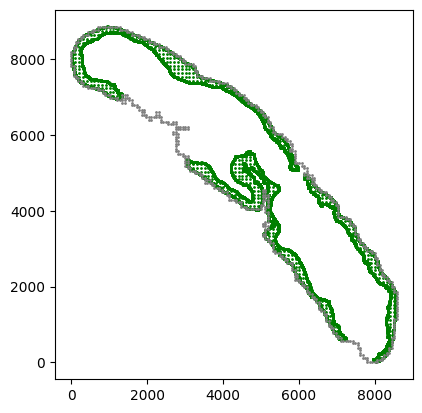

In [27]:
plt.scatter(ep_all_array[:, 0], ep_all_array[:, 1], color='green', s=1) # epithelium
plt.scatter(tissue_outline[:, 0], tissue_outline[:, 1], color='gray', s=1) # tissue outline
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### find longest lines

In [119]:
# Dict: groups points by y-coordinates
ep_groupedy = {}
for point in ep_all_array:
    x, y = point
    if y not in ep_groupedy:
        ep_groupedy[y] = []
    ep_groupedy[y].append(x)

# Initialize the longest series tracker
longest_horizontal = []
distance_threshold = 50  # Adjust as needed
tissue_outline_points = [Point(coord) for coord in tissue_outline]

# Iterate through each y and find the longest continuous series
for y, x_values in ep_groupedy.items():
    x_values = sorted(set(x_values))
    current_series = []

    for i in range(len(x_values)):
        # If it's the first value or continuous
        if i == 0 or (x_values[i] == x_values[i - 1] + 100):
            current_series.append((x_values[i], y))  # Store as (x, y) tuple
        else:
            # Check the current series only if not empty
            if current_series:
                start_point = Point(current_series[0])
                end_point = Point(current_series[-1])

                # Check if one endpoint is close to the tissue outline
                start_close = any(start_point.distance(tp) < distance_threshold for tp in tissue_outline_points)
                end_close = any(end_point.distance(tp) < distance_threshold for tp in tissue_outline_points)

                if (start_close and not end_close) or (not start_close and end_close):
                    # Update longest series if the current is longer
                    if len(current_series) > len(longest_horizontal):
                        longest_horizontal = current_series

            # Reset for the new series
            current_series = [(x_values[i], y)]

    # Final check for the last series
    if current_series:
        start_point = Point(current_series[0])
        end_point = Point(current_series[-1])
        start_close = any(start_point.distance(tp) < distance_threshold for tp in tissue_outline_points)
        end_close = any(end_point.distance(tp) < distance_threshold for tp in tissue_outline_points)

        if (start_close and not end_close) or (not start_close and end_close):
            if len(current_series) > len(longest_horizontal):
                longest_horizontal = current_series


In [114]:
# Dict: groups points by x-coordinates
ep_groupedx = {}
for point in ep_all_array:
    x, y = point
    if x not in ep_groupedx:
        ep_groupedx[x] = []
    ep_groupedx[x].append(y)

# Initialize the longest series tracker
longest_vertical = []
distance_threshold = 50  # Adjust as needed
tissue_outline_points = [Point(coord) for coord in tissue_outline]

# Iterate through each x and find the longest continuous series
for x, y_values in ep_groupedx.items():
    y_values = sorted(set(y_values))
    current_series = []

    for i in range(len(y_values)):
        # If it's the first value or continuous
        if i == 0 or (y_values[i] == y_values[i - 1] + 100):
            current_series.append((x, y_values[i]))  # Store as (x, y) tuple
        else:
            # Check the current series only if not empty
            if current_series:
                start_point = Point(current_series[0])
                end_point = Point(current_series[-1])

                # Check if one endpoint is close to the tissue outline
                start_close = any(start_point.distance(tp) < distance_threshold for tp in tissue_outline_points)
                end_close = any(end_point.distance(tp) < distance_threshold for tp in tissue_outline_points)

                if (start_close and not end_close) or (not start_close and end_close):
                    # Update longest series if the current is longer
                    if len(current_series) > len(longest_vertical):
                        longest_vertical = current_series

            # Reset for the new series
            current_series = [(x, y_values[i])]

    # Final check for the last series
    if current_series:
        start_point = Point(current_series[0])
        end_point = Point(current_series[-1])
        start_close = any(start_point.distance(tp) < distance_threshold for tp in tissue_outline_points)
        end_close = any(end_point.distance(tp) < distance_threshold for tp in tissue_outline_points)

        if (start_close and not end_close) or (not start_close and end_close):
            if len(current_series) > len(longest_vertical):
                longest_vertical = current_series

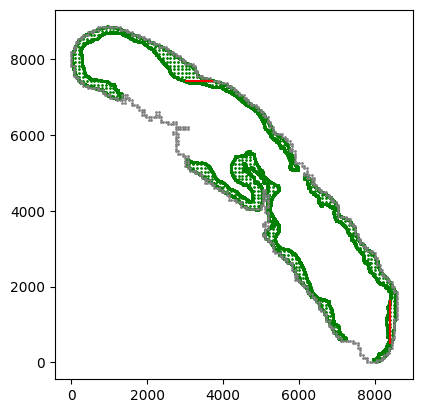

In [120]:
x_hor, y_hor = zip(*longest_horizontal)
x_vert, y_vert = zip(*longest_vertical)
plt.scatter(ep_all_array[:, 0], ep_all_array[:, 1], color='green', s=1) # epithelium
plt.scatter(tissue_outline[:, 0], tissue_outline[:, 1], color='gray', s=1) # tissue outline
plt.plot(x_hor, y_hor, color='red')  # longest horizontal
plt.plot(x_vert, y_vert, color='red')  # longest vertical
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### helper functions

In [121]:
def get_tissue_outline(tissue_geojson_path):
    gdf = gpd.read_file(tissue_geojson_path)
    polygon = gdf.geometry.values[0]
    tissue = polygon.exterior
    tissue_outline = np.array(tissue.coords)
    return tissue_outline

In [122]:
def get_ep_coords(ep_geojson_path):
    gdf = gpd.read_file(ep_geojson_path)
    ep_all = []

    for geom in gdf.geometry:
        if geom.is_empty:
            continue
        
        minx, miny, maxx, maxy = geom.bounds    # get bounding box
        print(f"Bounding box coordinates: minx={minx}, miny={miny}, maxx={maxx}, maxy={maxy}")
        
        # create points within the bounding box
        x_points = np.arange(minx, maxx, 100)  # adjust step size
        y_points = np.arange(miny, maxy, 100)  # adjust step size 
        grid_points = [Point(x, y) for x in x_points for y in y_points]
        print(f"Total grid points created: {len(grid_points)}")
        
        # filter grid points to keep only those within the geometry
        filled_points = [point for point in grid_points if geom.contains(point)]
        
        for point in filled_points:
            if isinstance(point, Point) and hasattr(point, 'x') and hasattr(point, 'y'):
                ep_all.append(np.array([point.x, point.y]))

    # combine all points into a single array
    ep_coords = np.vstack(ep_all) if ep_all else np.empty((0, 2))

    return ep_coords

In [156]:
def longest_horizontal(tissue_outline_coords, ep_coords):
    # Dict: groups points by y-coordinates
    ep_groupedy = {}
    for point in ep_coords:
        x, y = point
        if y not in ep_groupedy:
            ep_groupedy[y] = []
        ep_groupedy[y].append(x)

    # Initialize the longest series tracker
    longest_horizontal = []
    distance_threshold = 125  # Adjust as needed
    tissue_outline_points = [Point(coord) for coord in tissue_outline_coords]

    # Iterate through each y and find the longest continuous series
    for y, x_values in ep_groupedy.items():
        x_values = sorted(set(x_values))
        current_series = []

        for i in range(len(x_values)):
            # If it's the first value or continuous
            if i == 0 or (x_values[i] == x_values[i - 1] + 100):
                current_series.append((x_values[i], y))  # Store as (x, y) tuple
            else:
                # Check the current series only if not empty
                if current_series:
                    start_point = Point(current_series[0])
                    end_point = Point(current_series[-1])

                    # Check if one endpoint is close to the tissue outline
                    start_close = any(start_point.distance(tp) < distance_threshold for tp in tissue_outline_points)
                    end_close = any(end_point.distance(tp) < distance_threshold for tp in tissue_outline_points)

                    if (start_close and not end_close) or (not start_close and end_close):
                        # Update longest series if the current is longer
                        if len(current_series) > len(longest_horizontal):
                            longest_horizontal = current_series

                # Reset for the new series
                current_series = [(x_values[i], y)]

        # Final check for the last series
        if current_series:
            start_point = Point(current_series[0])
            end_point = Point(current_series[-1])
            start_close = any(start_point.distance(tp) < distance_threshold for tp in tissue_outline_points)
            end_close = any(end_point.distance(tp) < distance_threshold for tp in tissue_outline_points)

            if (start_close and not end_close) or (not start_close and end_close):
                if len(current_series) > len(longest_horizontal):
                    longest_horizontal = current_series

    return longest_horizontal

In [157]:
def longest_vertical(tissue_outline_coords, ep_coords):
    # Dict: groups points by x-coordinates
    ep_groupedx = {}
    for point in ep_coords:
        x, y = point
        if x not in ep_groupedx:
            ep_groupedx[x] = []
        ep_groupedx[x].append(y)

    # Initialize the longest series tracker
    longest_vertical = []
    distance_threshold = 125  # Adjust as needed
    tissue_outline_points = [Point(coord) for coord in tissue_outline_coords]

    # Iterate through each x and find the longest continuous series
    for x, y_values in ep_groupedx.items():
        y_values = sorted(set(y_values))
        current_series = []

        for i in range(len(y_values)):
            # If it's the first value or continuous
            if i == 0 or (y_values[i] == y_values[i - 1] + 100):
                current_series.append((x, y_values[i]))  # Store as (x, y) tuple
            else:
                # Check the current series only if not empty
                if current_series:
                    start_point = Point(current_series[0])
                    end_point = Point(current_series[-1])

                    # Check if one endpoint is close to the tissue outline
                    start_close = any(start_point.distance(tp) < distance_threshold for tp in tissue_outline_points)
                    end_close = any(end_point.distance(tp) < distance_threshold for tp in tissue_outline_points)

                    if (start_close and not end_close) or (not start_close and end_close):
                        # Update longest series if the current is longer
                        if len(current_series) > len(longest_vertical):
                            longest_vertical = current_series

                # Reset for the new series
                current_series = [(x, y_values[i])]

        # Final check for the last series
        if current_series:
            start_point = Point(current_series[0])
            end_point = Point(current_series[-1])
            start_close = any(start_point.distance(tp) < distance_threshold for tp in tissue_outline_points)
            end_close = any(end_point.distance(tp) < distance_threshold for tp in tissue_outline_points)

            if (start_close and not end_close) or (not start_close and end_close):
                if len(current_series) > len(longest_vertical):
                    longest_vertical = current_series
    
    return longest_vertical

In [158]:
def visualize(tissue_outline_coords, ep_coords, hor_line, vert_line):
    x_hor, y_hor = zip(*hor_line)
    x_vert, y_vert = zip(*vert_line)
    plt.scatter(ep_coords[:, 0], ep_coords[:, 1], color='green', s=1, label='Epithelium')  # epithelium
    plt.scatter(tissue_outline_coords[:, 0], tissue_outline_coords[:, 1], color='gray', s=1, label='Tissue Outline')  # tissue outline
    plt.plot(x_hor, y_hor, color='red')  # longest horizontal
    plt.plot(x_vert, y_vert, color='red')  # longest vertical
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [159]:
def pipeline(tissue_geojson_path, ep_geojson_path):
    tissue_outline_coords = get_tissue_outline(tissue_geojson_path)
    ep_coords = get_ep_coords(ep_geojson_path)
    hor_line = longest_vertical(tissue_outline_coords, ep_coords)
    vert_line = longest_horizontal(tissue_outline_coords, ep_coords)
    visualize(tissue_outline_coords, ep_coords, hor_line, vert_line)
    return hor_line, vert_line

### automate process

In [163]:
geojsons_path = 'geojsons'  
folders_dict = {}

for item in os.listdir(geojsons_path):
    item_path = os.path.join(geojsons_path, item)
    if os.path.isdir(item_path):
        folders_dict[item] = ['tissue.geojson', 'epithelium.geojson']

Bounding box coordinates: minx=15.0, miny=25.0, maxx=8548.0, maxy=8854.0
Total grid points created: 7654


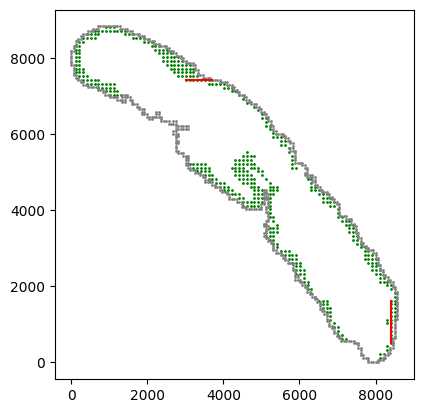

Bounding box coordinates: minx=27.0, miny=25.0, maxx=5868.0, maxy=3061.0
Total grid points created: 1829


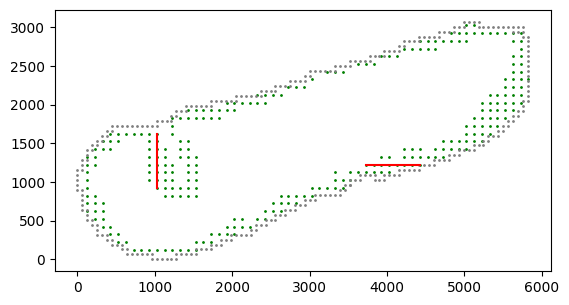

Bounding box coordinates: minx=24.0, miny=72.0, maxx=9270.0, maxy=2208.0
Total grid points created: 2046


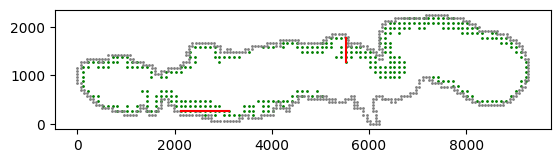

Bounding box coordinates: minx=53.0, miny=39.0, maxx=6421.0, maxy=4412.0
Total grid points created: 2816


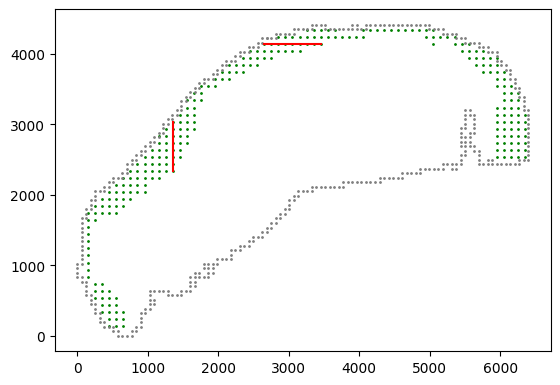

Bounding box coordinates: minx=59.0, miny=31.0, maxx=2958.0, maxy=5129.0
Total grid points created: 1479


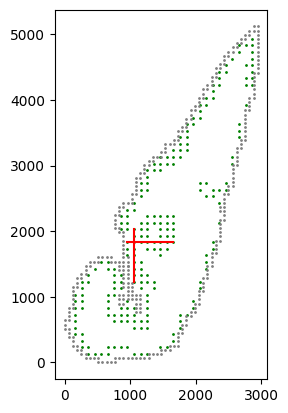

In [164]:
longest_lines_dict = {}

for folder, files in folders_dict.items():
    tissue_geojson_path = os.path.join(geojsons_path, folder, files[0])  # tissue.geojson
    ep_geojson_path = os.path.join(geojsons_path, folder, files[1])  # epithelium.geojson
    hor_line, vert_line = pipeline(tissue_geojson_path, ep_geojson_path)
    longest_lines_dict[folder] = {'horizontal': hor_line, 'vertical': vert_line}

In [165]:
folder_names = []
horizontal_lengths = []
vertical_lengths = []

for folder, lines in longest_lines_dict.items():
    folder_names.append(folder)
    horizontal_lengths.append(len(lines['horizontal']))
    vertical_lengths.append(len(lines['vertical']))

df = pd.DataFrame({
    'Patient': folder_names,
    'Horizontal': horizontal_lengths,
    'Vertical': vertical_lengths
})

df

,Patient,Horizontal,Vertical
0,h1810898A h&e_ROI_2,12,8
1,h1812404A h&e_ROI_1,8,8
2,h1825421 h&e_ROI_2,6,11
3,h1810898B h&e_ROI_3,8,9
4,h1817608C h&e_ROI_2,9,8
